# Solving a Data Fitting Problem

This data fitting quantum algorithm involves 3 sub-routines:
1. a quantum algorithm for performing a pseudo-inverse
2. an algorithm for estimating the fit quality
3. an algorithm for learning the fit parameters $\lambda$

Input: 
- quantum state $|y\rangle$
- upper bound $\kappa$ square root of the conditional number $FF^{\dag}$ and $F^{\dag}F$
- sparseness $s$ of $F$
- error tolerance $\epsilon$

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
#from qiskit.algorithms import plot_histogram

## Sub-Routine 1: Pseudo-Inverse

Also, we set additional specifications for $F$ and $y$. $F \in \mathbb{R}^{4\times3}$. And $y \in \mathbb{R}^4$, not a linear combination of the columns of $F$

See below we define an $F$ with rank 3 and a $y$ that isn't a linear combination of $F$'s columns

In [2]:
F = np.matrix([[1, 1, 1], [0, 0, 1], [1, 0, 0], [0.5, 1, 0]])


print("rank", np.linalg.matrix_rank(F))

y = np.array([0, 0, 1, 0])
y.resize((4, 1))
print("F=", F)
print("y=", y)

rank 3
F= [[1.  1.  1. ]
 [0.  0.  1. ]
 [1.  0.  0. ]
 [0.5 1.  0. ]]
y= [[0]
 [0]
 [1]
 [0]]


The data fitting problem starts with the need to solving the equation.
$$\lambda = F^{+}y$$


Where $F^{+} = (F^{\dag}F)^{-1}F^{\dag}$. However, the inverse operation is computationally expensive, so we can construct the problem as follows:
$$
    (F^\dag F )\lambda = F^\dag y
$$
Which can be solved efficiently using HHL, where $A = F^\dag F$ and $b = F^\dag y$. $A$ is $3\times3$ however, so we need to pad it for its dimensions to be a power of $2$.

In [3]:
A = F.getH() * F

A = np.pad(A, ((0, 1), (0, 1)))
A[-1][-1] = 1 

b = F.getH() * y
b = np.vstack((b, [0]))

## Sub-Routine 2: Estimating Fit Quality

In [4]:
from qiskit.algorithms.linear_solvers.hhl import HHL

backend = Aer.get_backend('aer_simulator')
hhl = HHL(quantum_instance=backend)
accurate_solution = hhl.solve(A, b)


C:\Users\jberm\AppData\Local\Temp\ipykernel_36484\305850212.py:4: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  hhl = HHL(quantum_instance=backend)


We must perform the swap test to distinguish between $|y\rangle$ and $I(F)|\lambda\rangle$. The overlap of these two quantum states can be learned through repeated sampling of this swap test to get the approximate value $|\langle y|I(F)|\lambda\rangle|^2$ of the mean of the distribution. The fit quality $E$ can be estimated to be less than $2(1-|\langle y|I(F)|\lambda\rangle|)$. 

## Sub-Routine 3: Learning Lambda

This routine involves repeatedly sampling the solution lambda output from HHL. 

In [5]:
nShots = 10000

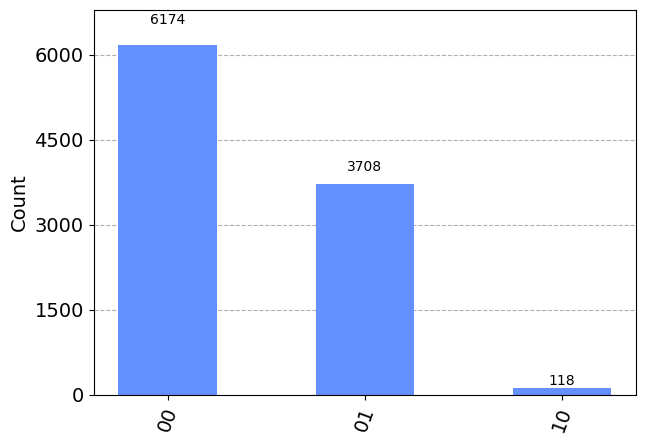

In [6]:
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(c)

lambda_circ = accurate_solution.state
lambda_circ = lambda_circ.compose(qc)
lambda_circ.measure(range(2), c)


backend_qasm = Aer.get_backend('qasm_simulator')
res = execute(lambda_circ, backend_qasm, shots=nShots).result() 

counts = res.get_counts()
plot_histogram(counts)    


From this histogram we have the relative importance of each of the fit values and are able to obtain $|lambda\rangle$ with confidence computed from sub-routine 2. It is apparent that because we padded $|b\rangle$ with a single $0$ that there is no likelihood of observing $11\rangle$.